In [1]:
from qaoa.initialstates import LessThanK, Tensor
from qaoa.mixers import Grover

Create a circuit for $\ket{ltk3} = \ket{00} + \ket{01} + \ket{11}$

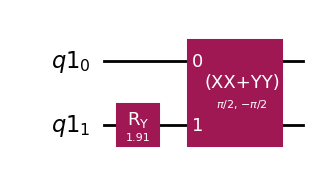

In [2]:
ltk3 = LessThanK(3)
ltk3.create_circuit()
ltk3.circuit.draw("mpl")

Create a circuit for $\ket{ltk3}^{\otimes 3}$

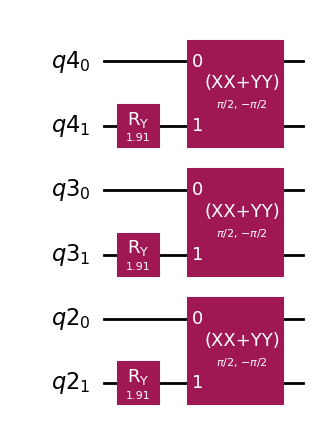

In [3]:
numNodes = 3
phi0 = Tensor(ltk3, numNodes)
phi0.create_circuit()
phi0.circuit.draw("mpl")

create the Grover mixer for $\ket{ltk3}^{\otimes 3}$

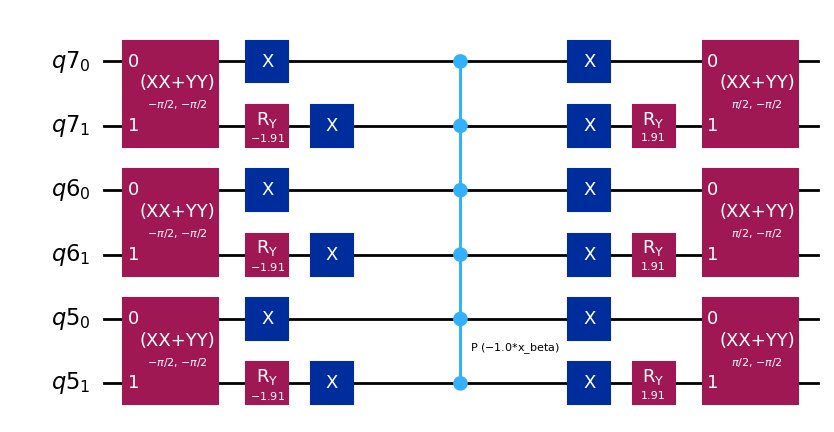

In [4]:
grover = Grover(phi0)
grover.create_circuit()
grover.circuit.draw("mpl")

create the Grover mixer for $\ket{ltk3}$ for 3 nodes using the box product

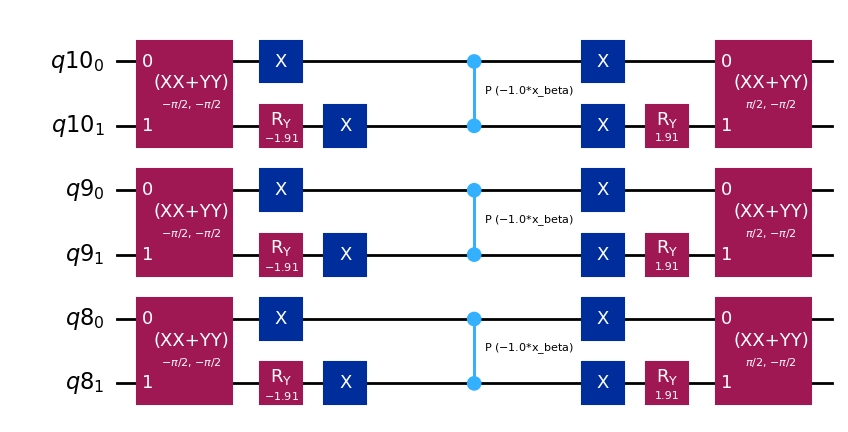

In [5]:
numNodes = 3
grover = Tensor(Grover(ltk3), numNodes)
grover.create_circuit()
grover.circuit.draw("mpl")

Picking two feasible states $\ket{z_1}, \ket{z_2}$, plot the overlap $\bra{z_1} U_M(\beta) \ket{z_2}$

In [6]:
import numpy as np
import matplotlib.pyplot as pl
from tqdm import tqdm

In [7]:
from qiskit_aer import Aer
from qiskit import (
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    transpile,
)
backend=Aer.get_backend("qasm_simulator")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.34it/s]


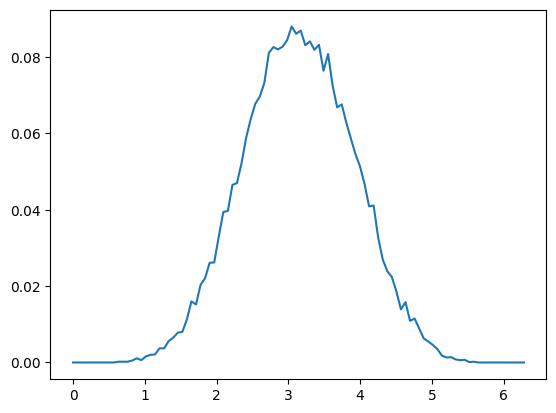

In [8]:
overlap = []
betavalues = np.linspace(0,2*np.pi,100)
shots=10**4
for beta in tqdm(betavalues):
    q = QuantumRegister(numNodes*2)
    c = ClassicalRegister(numNodes*2)
    circuit = QuantumCircuit(q, c)
    for k in range(numNodes):
        circuit.x(0+k*2)
    circuit.barrier()
    circuit.append(grover.circuit, q)
    circuit.measure(q, c)
    circuit = transpile(circuit, backend)
    
    # Assign float values to the parameters
    parameters = list(circuit.parameters)
    parameter_values = [beta]
    bound_circuit = circuit.assign_parameters(dict(zip(parameters, parameter_values)))
    
    # Draw the bound circuit (optional)
    
    # Run the job
    job = backend.run(bound_circuit, shots=shots)
    counts = job.result().get_counts()
    overlap.append(counts.get("10"*numNodes,0.)/shots)
    
# bound_circuit.draw('mpl')

pl.plot(betavalues, overlap)
